# A Comprehensive Guide to Data Cleaning

In data analysis and machine learning, data is everything. The adage "garbage in garbage out" couldn't ring truer. The foundation of any meaningful data work and product lies in clean and reliable data, yet data in the real world seldom arrives clean.

Whether scraped from the web or obtained through various sources, chances are that raw datasets often contain inconsistencies, errors, and missing values, rendering them unfit for analysis and modeling.

**Purpose:** This guide will walk you through the process of data cleaning, covering techniques, best practices, and tools needed to turn messy, raw data into clean, organized data ready for analysis and modeling. We'll discuss each step in detail, making it easy to understand and apply these concepts to your own data projects.

As we all know, clean data sparks joy. Happy learning! 😊

In [1]:
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

# 1. Generate Data

For this tutorial, we will use a synthetic dataset that allows us to explore techniques and best procedures for data cleaning.

In [2]:
random.seed(42)
np.random.seed(42)

# Generate unique sample email addresses and postal codes
emails = [f'user{i}@example.com' for i in range(1, 101)]
postal_codes = [f'{np.random.randint(10000, 99999)}' for _ in range(100)]

# generate data
data = {
    'ID': range(1, 101),
    'Age': [random.choice([25, 30, 35, 40, 45, 50, 60, 70]) for _ in range(100)],
    'Gender': [random.choice(['M', 'F', 'Male', 'Female', 'male', 'female']) for _ in range(100)],
    'Income': [random.choice([30000, 50000, 70000, 90000, 110000, np.nan]) for _ in range(100)],
    'Date of Joining': pd.date_range(start='1/1/2020', periods=100, freq='D').strftime('%Y-%m-%d').tolist(),
    'City': [random.choice(['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'New york', 'los angeles', 'chicago', 'HOUSTON', 'phoenix', np.nan]) for _ in range(100)],
    'Happiness Score': [random.choice([50, 60, 70, 80, 90, 100, 150, 200]) for _ in range(100)],
    'Email_Postal': [f"{random.choice(emails)},{random.choice(postal_codes)}" for _ in range(100)],
    'Education': [f"{random.choice(['Bachelor', 'Master', 'PhD'])}" for _ in range(100)]
}

# create dataframe
df = pd.DataFrame(data)

# add outliers
outlier_indices = random.sample(range(len(df)), 2)
df.loc[outlier_indices, 'Income'] = df.loc[outlier_indices, 'Income'] * 10

# add duplicate rows
duplicate_indices = random.sample(range(len(df)), 3)  # Select 3 random indices to duplicate
df = pd.concat([df, df.loc[duplicate_indices]], ignore_index=True)  # Append duplicate rows to the DataFrame

When we work on a new dataset, it is a good idea to perform an initial inspection and sanity check.

| Method      | Step |
| ----------- | ----------- |
| `df.head()`      | First 5 rows       |
| `df.tail()`      | Last 5 rows       |
| `df.shape`   | No. of rows and columns |
| `df.describe()` | Statistics summary |
| `df.info()` | General info |

In [3]:
df.tail()

,ID,Age,Gender,Income,Date of Joining,City,Happiness Score,Email_Postal,Education
98,99,30,M,110000.0,2020-04-08,New York,200,"user31@example.com,72955",PhD
99,100,60,M,30000.0,2020-04-09,Los Angeles,70,"user61@example.com,96779",Bachelor
100,93,30,M,110000.0,2020-04-02,Phoenix,150,"user84@example.com,54131",Master
101,53,70,M,30000.0,2020-02-22,chicago,90,"user53@example.com,97313",Master
102,63,35,F,50000.0,2020-03-03,NaN,150,"user97@example.com,78148",Master


Notice that there are inconsistencies in `Gender`, `City` columns. (E.g. Female and F are both referring to "Female")

In [4]:
df.shape

(103, 9)

In [5]:
df.describe()

,ID,Age,Income,Happiness Score
count,103.000000,103.000000,88.000000,103.000000
mean,51.058252,42.815534,67954.545455,99.029126
std,28.911910,13.073508,29249.583587,40.789141
min,1.000000,25.000000,30000.000000,50.000000
25%,26.500000,30.000000,50000.000000,70.000000
50%,52.000000,40.000000,70000.000000,90.000000
75%,75.500000,50.000000,90000.000000,125.000000
max,100.000000,70.000000,110000.000000,200.000000


This gives us the statistical summary. At a glance, we get information such as mean, median, count, standard deviation, minimum and maximum.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               103 non-null    int64  
 1   Age              103 non-null    int64  
 2   Gender           103 non-null    object 
 3   Income           88 non-null     float64
 4   Date of Joining  103 non-null    object 
 5   City             90 non-null     object 
 6   Happiness Score  103 non-null    int64  
 7   Email_Postal     103 non-null    object 
 8   Education        103 non-null    object 
dtypes: float64(1), int64(3), object(5)
memory usage: 7.4+ KB


Here we see that `Income` and `City` have missing values. `Date of Joining` is a datetime but data is stored as object. These need to be handled later on.

# 2. Standardization

Often, converting text to lowercase and replacing spaces or special characters with underscores help ensure consistency and avoid errors.

In [7]:
# standardize column names
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace(r'\W', '', regex=True)
df.columns

Index(['id', 'age', 'gender', 'income', 'date_of_joining', 'city',
       'happiness_score', 'email_postal', 'education'],
      dtype='object')

In [8]:
# standardize values in city
df.city.value_counts(dropna=False)

city
Phoenix        15
Los Angeles    13
NaN            13
phoenix        11
HOUSTON        10
Chicago         8
Houston         8
New York        7
New york        7
chicago         6
los angeles     5
Name: count, dtype: int64

Phoenix and phoenix, New York and New york. These pairs refer to the same location. One way to standardize is to lowercase the values. (Missing value will be handled later)

In [9]:
df.city = df.city.str.lower()
df.city.unique()

array(['chicago', 'los angeles', 'phoenix', nan, 'houston', 'new york'],
      dtype=object)

In [10]:
# standardize values in gender
df.gender.value_counts()

gender
M         22
male      21
F         18
female    17
Male      14
Female    11
Name: count, dtype: int64

Here, we need to combine {male, M, and Male} to "M", and do the same for female. For this case, we can simply uppercase the values and keep the first letter.

In [11]:
df.gender = df.gender.str.upper().str[0]
df.gender.unique()

array(['F', 'M'], dtype=object)

In [12]:
df.head()

,id,age,gender,income,date_of_joining,city,happiness_score,email_postal,education
0,1,30,F,70000.0,2020-01-01,chicago,60,"user85@example.com,26023",Bachelor
1,2,25,M,30000.0,2020-01-02,los angeles,70,"user37@example.com,55758",PhD
2,3,45,F,110000.0,2020-01-03,phoenix,50,"user85@example.com,19268",Bachelor
3,4,40,M,50000.0,2020-01-04,los angeles,100,"user80@example.com,97313",Master
4,5,40,M,70000.0,2020-01-05,NaN,70,"user12@example.com,12695",PhD


# 3. Data Types

In Python, basic data types are like the building blocks of a structure. They're the simple pieces you use to represent different kinds of information in your code. They include things like numbers, words, and true/false values. These data types are the foundation of almost every Python program, helping you work with different kinds of data easily.

| Method      | Step |
| ----------- | ----------- |
| `df.dtypes`      | Check data types       |
| `df.astype()`      | Convert data types       |

In [13]:
df.dtypes

id                   int64
age                  int64
gender              object
income             float64
date_of_joining     object
city                object
happiness_score      int64
email_postal        object
education           object
dtype: object

Convert date_of_joining to datetime dtype.

In [14]:
df['date_of_joining'] = pd.to_datetime(df['date_of_joining'], format='%Y-%m-%d')

# 4. Remove Duplicates

Duplicate rows can distort statistical analyses and machine learning models. Removing duplicates improves data quality.

| Method      | Step |
| ----------- | ----------- |
| `df.duplicated()`      | Identify duplicates       |
| `df.drop_duplicates()`      | Remove duplicate rows       |

In [15]:
# identify duplicates
duplicate_mask = df.duplicated()
print(f'No of duplicate rows: {duplicate_mask.sum()}')

No of duplicate rows: 3


In [16]:
# remove duplicate rows
df = df.drop_duplicates()
df.duplicated().sum()

0

# 5. Missing Values

Handling missing data is a crucial step in data cleaning as it ensures the dataset is complete and reliable for analysis. Identifying missing values can be done using `df.isnull().sum()`. Once identified, missing data can be imputed using either `sklearn.impute` or `pd.fillna()`

A quick guide in **selecting the values to impute** for missing data:
1. Numeric data: impute with mean/median (to preserve central tendency/distribution) or mode
2. Categorical data: impute with most frequent category or creating a new label "Unknown"
3. Time series: impute using linear interpolation or forward/backward filling if data exhibits a trend

In [17]:
df.isnull().sum()

id                  0
age                 0
gender              0
income             15
date_of_joining     0
city               12
happiness_score     0
email_postal        0
education           0
dtype: int64

Since `income` is numerical data, let's impute missing values with mean.

In [18]:
mean_income = df.income.mean()
df['income'] = df['income'].fillna(mean_income)

In [19]:
df.city.value_counts(dropna=False)

city
phoenix        25
los angeles    18
houston        18
new york       14
chicago        13
NaN            12
Name: count, dtype: int64

Since `city` is categorical data without a clear majority, let's impute missing values with "Unknown"

In [20]:
df['city'] = df['city'].fillna("Unknown")

In [21]:
# final check: no missing values
df.isnull().sum()

id                 0
age                0
gender             0
income             0
date_of_joining    0
city               0
happiness_score    0
email_postal       0
education          0
dtype: int64

# 6. Handle Outliers

Treating outliers is an essential step to ensure that anomalous data points do not unduly influence statistical analyses or machine learning models. Visualizing the data distribution using techniques such as boxplots, scatterplots, and distribution plots helps identify outliers visually.

Earlier, from `df.describe()`, we notice a possible skew/outlier in `income` column. Let's visualize this column as a boxplot.

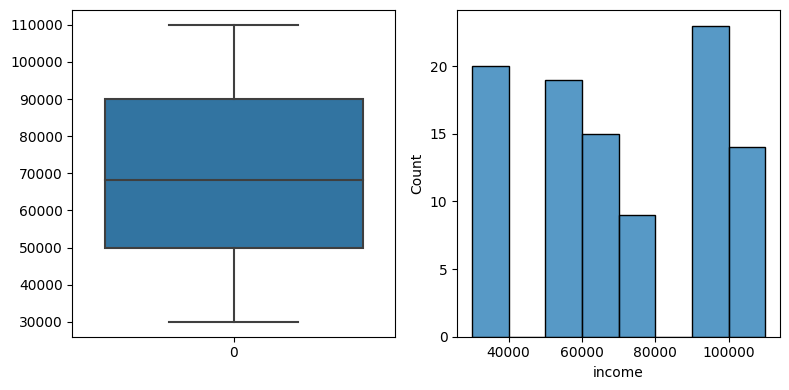

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
sns.boxplot(df.income)

plt.subplot(1,2,2)
sns.histplot(df.income)

plt.tight_layout()

From the plots, there seems to be a few outlier points in the `income` column.

Note: we remove outliers when (a) it represents data quality issues or (b) it significantly affects the results or assumptions of the analysis. Conversely, outliers may be retained if they represent genuine variability in the data, rare events of interest, or insights derived from domain knowledge.

In our case, we assume there are data quality issues. Let's remove the outliers.

In [23]:
df.income.sort_values(ascending=False).head()

50    110000.0
8     110000.0
75    110000.0
84    110000.0
86    110000.0
Name: income, dtype: float64

One outlier point spotted.

In [24]:
outlier_threshold = 200000

# remove outlier
df = df.loc[df.income <= outlier_threshold]

In [25]:
df.shape

(100, 9)

In [26]:
df.income.sort_values(ascending=False).head()

50    110000.0
8     110000.0
75    110000.0
84    110000.0
86    110000.0
Name: income, dtype: float64

# 7. String Manipulation

Sometimes, data can be merged into one value and requires string manipulation to clean the data

In [27]:
df.head()

,id,age,gender,income,date_of_joining,city,happiness_score,email_postal,education
0,1,30,F,70000.0,2020-01-01,chicago,60,"user85@example.com,26023",Bachelor
1,2,25,M,30000.0,2020-01-02,los angeles,70,"user37@example.com,55758",PhD
2,3,45,F,110000.0,2020-01-03,phoenix,50,"user85@example.com,19268",Bachelor
3,4,40,M,50000.0,2020-01-04,los angeles,100,"user80@example.com,97313",Master
4,5,40,M,70000.0,2020-01-05,Unknown,70,"user12@example.com,12695",PhD


In this scenario, we want to split `email_postal` into 3 columns - `name` (user 85) `email` (user85@example.com) `postal` (26023). We can use string functions or regex to process the text data.

In [28]:
# splits email_postal on ","
df[['email', 'postal']] = df['email_postal'].str.split(',', expand=True)

In [29]:
# extracts text infront of "@" symbol and assign it to `name` column
df['name'] = df['email'].str.extract(r'^(.*)@')

In [30]:
df.drop(columns='email_postal',inplace=True)
df.head()

,id,age,gender,income,date_of_joining,city,happiness_score,education,email,postal,name
0,1,30,F,70000.0,2020-01-01,chicago,60,Bachelor,user85@example.com,26023,user85
1,2,25,M,30000.0,2020-01-02,los angeles,70,PhD,user37@example.com,55758,user37
2,3,45,F,110000.0,2020-01-03,phoenix,50,Bachelor,user85@example.com,19268,user85
3,4,40,M,50000.0,2020-01-04,los angeles,100,Master,user80@example.com,97313,user80
4,5,40,M,70000.0,2020-01-05,Unknown,70,PhD,user12@example.com,12695,user12


## Advanced Data Processing
---

# 8. Encoding Categorical Data

Encoding categorical data is important because many machine learning algorithms can only work with numerical data. Categorical data, like gender and cities, needs to be turned into numbers so the algorithms can understand it. We do this encoding step before training our models. It helps the models learn from the data and make accurate predictions.

| Method      | Step |
| ----------- | ----------- |
| `LabelEncoder`      | Label encoding        |
| `OneHotEncoder`      | One-hot encoding        |
| `TargetEncoder`      | Target encoding        |

We use different encoding methods based on the type of categorical data and the requirements of our machine learning task:

`LabelEncoder`: We use Label encoding when we have ordinal categorical data, where there's a natural order or ranking among the categories. For example, education levels like "high school," "college," and "graduate" can be encoded as 0, 1, and 2, respectively.

`OneHotEncoder`: One-hot encoding is used when we have nominal categorical data, where there's no inherent order among the categories. Each category is represented by a binary column, with 1 indicating the presence of the category and 0 indicating absence. This method is suitable when the number of categories is relatively small.

`TargetEncoder`: Target encoding is used when we have high-cardinality categorical features (i.e., features with a large number of unique categories) and we want to encode them based on their relationship with the target variable. It replaces each category with the mean of the target variable for that category. This method is useful for preventing overfitting and capturing category-level information in the target variable.

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'chicago'),
  Text(1, 0, 'los angeles'),
  Text(2, 0, 'phoenix'),
  Text(3, 0, 'Unknown'),
  Text(4, 0, 'houston'),
  Text(5, 0, 'new york')])

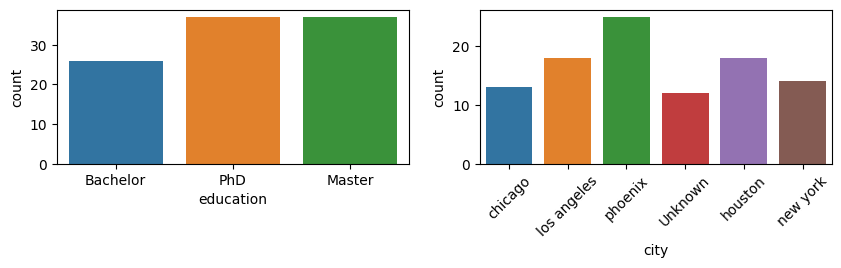

In [31]:
plt.figure(figsize=(10,2))

plt.subplot(121)
sns.countplot(df, x='education')

plt.subplot(122)
sns.countplot(df, x='city')
plt.xticks(rotation=45)

We will use `LabelEncoder` for `education` as there is a natural ranking within the category

In [32]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(['Bachelor', 'Master', 'PhD'])

df['education_enc'] = label_encoder.transform(df['education'])
df[['education', 'education_enc']].head()

,education,education_enc
0,Bachelor,0
1,PhD,2
2,Bachelor,0
3,Master,1
4,PhD,2


We will use `OneHotEncoder` for `city` as the number of categories are small and there is no natural order within the category

In [33]:
from sklearn.preprocessing import OneHotEncoder # pd.get_dummies work too

ohe = OneHotEncoder()

ohe.fit(df[['city']])
ohe.categories_

[array(['Unknown', 'chicago', 'houston', 'los angeles', 'new york',
        'phoenix'], dtype=object)]

In [34]:
feature_names = ohe.get_feature_names_out(['city'])

enc_df = pd.DataFrame(ohe.transform(df[['city']]).toarray(), columns=feature_names)
enc_df.head()

,city_Unknown,city_chicago,city_houston,city_los angeles,city_new york,city_phoenix
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# merge main df with ohe df
df = df.join(enc_df)
df.head()

,id,age,gender,income,date_of_joining,city,happiness_score,education,email,postal,name,education_enc,city_Unknown,city_chicago,city_houston,city_los angeles,city_new york,city_phoenix
0,1,30,F,70000.0,2020-01-01,chicago,60,Bachelor,user85@example.com,26023,user85,0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,25,M,30000.0,2020-01-02,los angeles,70,PhD,user37@example.com,55758,user37,2,0.0,0.0,0.0,1.0,0.0,0.0
2,3,45,F,110000.0,2020-01-03,phoenix,50,Bachelor,user85@example.com,19268,user85,0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,40,M,50000.0,2020-01-04,los angeles,100,Master,user80@example.com,97313,user80,1,0.0,0.0,0.0,1.0,0.0,0.0
4,5,40,M,70000.0,2020-01-05,Unknown,70,PhD,user12@example.com,12695,user12,2,1.0,0.0,0.0,0.0,0.0,0.0


# 9. Normalize (Scale) Data

Normalization is the process of rescaling numerical data to a common scale, often between 0 and 1, to facilitate comparison and analysis.

This is important for ML regression tasks because it ensures all input features are on a similar scale, preventing certain features from disproportionately influencing the model's training process.

| Method      | Step |
| ----------- | ----------- |
| `MinMaxScaler`      | 0 to 1 scaler        |
| `StandardScaler`      | Z-normalization        |
| `Normalizer`      | Normalizer        |

1. **MinMaxScaler**: This method scales the data to a specified range, typically between 0 and 1. It subtracts the minimum value from each feature and then divides by the range (maximum value minus minimum value). Min-max scaling preserves the original distribution of the data while ensuring that all features are within the specified range.

2. **StandardScaler**: StandardScaler standardizes the data by removing the mean and scaling to unit variance. It transforms the data such that it has a mean of 0 and a standard deviation of 1. This technique is suitable when the data follows a Gaussian distribution and helps algorithms converge faster.

3. **Normalizer**: Normalizer scales each data point independently to have a unit norm (the sum of squares of each feature equals 1). It is applied to each row of the dataset rather than to the entire dataset. Normalizer is useful when the magnitude of the data is not relevant for the model, such as in text classification or clustering tasks.

In our case, we want to build a regression model using income and age to predict happiness_score.

In [36]:
df[['income', 'age', 'happiness_score']].head()

,income,age,happiness_score
0,70000.0,30,60
1,30000.0,25,70
2,110000.0,45,50
3,50000.0,40,100
4,70000.0,40,70


Scaling is necessary in this case because the features `income` and `age` have different scales. `Income` values are typically much larger than `age` values, which can cause issues during model training. If one feature dominates the other due to its larger scale, the model may become biased and give undue importance to that feature. Scaling ensures that both features contribute equally to the model's learning process.

For this regression task,we will use `StandardScaler`. `StandardScaler` transforms the data to have a mean of 0 and a standard deviation of 1. This ensures that both `income` and `age` are on the same scale, making it easier for the model to learn their respective contributions to predicting "happiness_score." Additionally, `StandardScaler` is robust to outliers and works well with most machine learning algorithms.

In [37]:
from sklearn.preprocessing import StandardScaler

features_to_scale = ['income', 'age']
scaler = StandardScaler()

df_scaled = df.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])

df_scaled[['income', 'age', 'happiness_score']].head()

,income,age,happiness_score
0,0.070694,-0.993527,60
1,-1.431550,-1.383146,70
2,1.572938,0.175328,50
3,-0.680428,-0.214290,100
4,0.070694,-0.214290,70


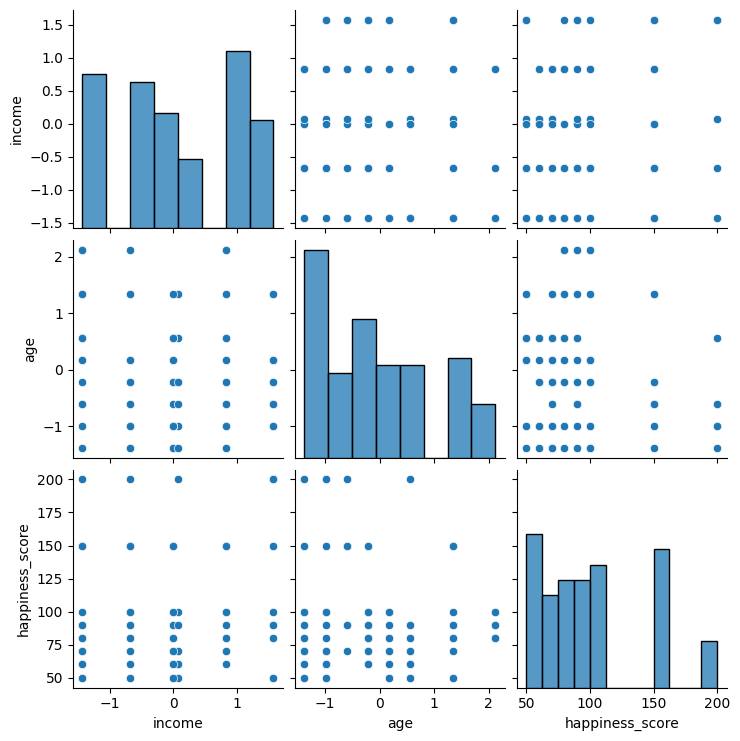

In [38]:
sns.pairplot(df_scaled[['income', 'age', 'happiness_score']])

# 10. Feature Engineering

Lastly, we will cover feature engineering briefly. This doesn't traditionally come under "data cleaning" but it's good to touch on it a little. 

Feature engineering enhances model performance by creating or transforming features to better represent the underlying patterns in the data, leading to more accurate predictions and improved model interpretability.

Common FE processes:

| Step      | Method |
| ----------- | ----------- |
| Create new features | `df['new_feature'] = df['col1'] / df['col2']` |
| Log transformation | `np.log1p()`, `np.log()` |
| Binning | `pd.cut()`, `pd.qcut()` |
| Date time | `df['year'] = pd.to_datetime(df['date_column']).dt.year` |
| Value mapping | `mapping = {'Low' : 0, 'High': 1}`, `df['mapped'] = df['feature'].map(mapping)` |






In [39]:
# Extracting year, month, day from datetime
df['year'] = df['date_of_joining'].dt.year
df['month'] = df['date_of_joining'].dt.month
df['day'] = df['date_of_joining'].dt.day

df[['date_of_joining', 'year', 'month', 'day']].head()

,date_of_joining,year,month,day
0,2020-01-01,2020,1,1
1,2020-01-02,2020,1,2
2,2020-01-03,2020,1,3
3,2020-01-04,2020,1,4
4,2020-01-05,2020,1,5


<Axes: xlabel='income', ylabel='Count'>

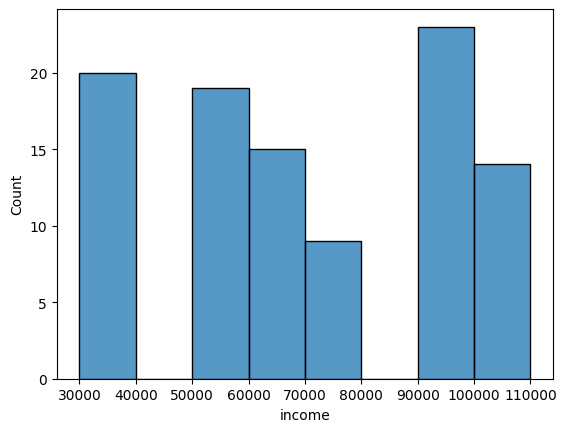

In [40]:
# Binning income groups
sns.histplot(df.income)

In [41]:
# bin edges
bins = np.arange(0, 120001, 20000)

# define bin labels
labels = [f'{i//1000}-{(i+20000)//1000}K' for i in range(0, 120000, 20000)]
labels[-1] = '100K+'

# bin income groups
df['income_groups'] = pd.cut(df['income'], bins=bins, labels=labels, right=False)

df[['income', 'income_groups']].head()

,income,income_groups
0,70000.0,60-80K
1,30000.0,20-40K
2,110000.0,100K+
3,50000.0,40-60K
4,70000.0,60-80K


# 11. Summary

Mastering data cleaning techniques is essential for ensuring accurate analyses and reliable machine learning models. By addressing issues like missing data, outliers, and categorical variables, and by scaling and engineering features, you can enhance the quality of your data and models.

If you found this resource on data cleaning techniques helpful, please consider giving it an upvote. Your support helps learning resources like this reach more people, benefiting fellow data science learners and practitioners. Thank you 😊